In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import math
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import os
import sys

In [2]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.0.0+cu117
device: cuda


In [4]:
#dataset loading
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
mean = (0.5,)
std = (0.5,)
test_images = ImageFolder( "../data/unet_test", transform = ImageTransform(mean, std))
test_loader = DataLoader(test_images, batch_size = 1, shuffle = False, drop_last=True)

In [5]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv11 = nn.Conv2d(1024, 512, 2, padding="same")
        self.conv12 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv14 = nn.Conv2d(512, 256, 2, padding="same")
        self.conv15 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv16 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv17 = nn.Conv2d(256, 128, 2, padding="same")
        self.conv18 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv19 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv20 = nn.Conv2d(128, 64, 2, padding="same")
        self.conv21 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv23 = nn.Conv2d(64, 2, 3, padding=1)
        self.conv24 = nn.Conv2d(2, 1, 1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
    
        # # self.label_emb = nn.Embedding(class_num, class_num)
        
        # self.model = nn.Sequential(
        #     nn.Conv2d(1, 64, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(64, 64, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(64, 128, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(128, 128, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(128, 256, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(256, 512, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(512, 512, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(512, 1024, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(1024, 1024, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.Conv2d(1024, 512, 3, padding=1),
        #     nn.ReLU(True),


        #     nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
        #     nn.BatchNorm2d(ngf * 32),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 16),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 8),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 4),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 2),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
        #     nn.BatchNorm2d(ngf),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
        #     nn.Tanh()
        # )
    
    def forward(self, x):

        conv1 = self.conv1(x)
        conv1 = self.relu(conv1)
        conv1 = self.conv2(conv1)
        conv1 = self.relu(conv1)
        pool1 = self.maxpool(conv1)
        conv2 = self.conv3(pool1)
        conv2 = self.relu(conv2)
        conv2 = self.conv4(conv2)
        conv2 = self.relu(conv2)
        pool2  =self.maxpool(conv2)
        conv3 = self.conv5(pool2)
        conv3 = self.relu(conv3)
        conv3 = self.conv6(conv3)
        conv3 = self.relu(conv3)
        pool3 = self.maxpool(conv3)
        conv4 = self.conv7(pool3)
        conv4 = self.relu(conv4)
        conv4 = self.conv8(conv4)
        conv4 = self.relu(conv4)
        drop4 = self.dropout(conv4)
        pool4 = self.maxpool(drop4)
        conv5 = self.conv9(pool4)
        conv5 = self.relu(conv5)
        conv5 = self.conv10(conv5)
        conv5 = self.relu(conv5)
        drop5 = self.dropout(conv5)
        up6 = self.up(drop5)
        up6 = self.conv11(up6)
        up6 = self.relu(up6)
        merge6 = torch.cat((drop4, up6), 1)
        conv6 = self.conv12(merge6)
        conv6 = self.relu(conv6)
        conv6 = self.conv13(conv6)
        conv6 = self.relu(conv6)
        up7 = self.up(conv6)
        up7 = self.conv14(up7)
        up7 = self.relu(up7)
        merge7 = torch.cat((conv3, up7), 1)
        conv7 = self.conv15(merge7)
        conv7 = self.relu(conv7)
        conv7 = self.conv16(conv7)
        conv7 = self.relu(conv7)
        up8 = self.up(conv7)
        up8 = self.conv17(up8)
        up8 = self.relu(up8)
        merge8 = torch.cat((conv2, up8), 1)
        conv8 = self.conv18(merge8)
        conv8 = self.relu(conv8)
        conv8 = self.conv19(conv8)
        conv8 = self.relu(conv8)
        up9 = self.up(conv8)
        up9 = self.conv20(up9)
        up9 = self.relu(up9)
        merge9 = torch.cat((conv1, up9), 1)
        conv9 = self.conv21(merge9)
        conv9 = self.relu(conv9)
        conv9 = self.conv22(conv9)
        conv9 = self.relu(conv9)
        conv9 = self.conv23(conv9)
        conv9 = self.relu(conv9)
        conv10 = self.conv24(conv9)
        output = self.tanh(conv10)
        
        return output

In [6]:
pretrained_model = "../model/googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# ネットワークの初期化
model1 = Net().to(device)
# 訓練済みモデルのロード
model1.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model1.eval()
model2 = Net().to(device)
# 訓練済みモデルのロード
model2.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model2.eval()

for param in model1.parameters():
    param.requires_grad = False
for param in model2.parameters():
    param.requires_grad = False

CUDA Available:  True


In [7]:
unet = Unet().to(device)
unet.load_state_dict(torch.load("../model/unet2+defensive.pth", map_location="cpu"))
unet.eval()

Unet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (conv12): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 3

In [8]:
def attack(data, data_grad, target, model, dirname_res, dirname_pro, chr, count, epsilon, lim, success):
    os.makedirs(dirname_pro + chr + "/{}".format(count), exist_ok=True)
    # os.makedirs(dirname_pro + chr + "/{}".format(i), exist_ok=True)
    for i in range(1, 1001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        # perturbed_data += (perturbed_data < torch.Tensor([1 - lim]).to("cuda")) * epsilon + (perturbed_data < torch.Tensor([0]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([-1 + lim]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([0]).to("cuda")) * epsilon
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        if pred.item() != target.item():
            success += 1
            break
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    return data, pred, success, i

/home/hoge/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hoge/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)


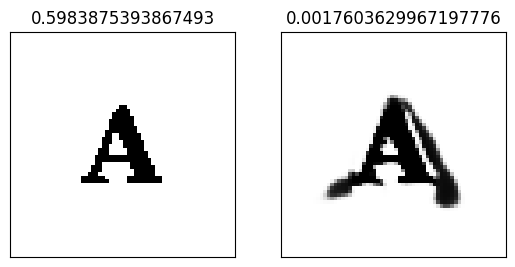

In [9]:
chr_lambda = lambda a: chr(a + 65)
dirname_grad = "../unet_attack_result" + "/grad/"
dirname_org = "../unet_attack_result" + "/org/"
dirname_adv = "../unet_attack_result" + "/adv/"
dirname_res = "../unet_attack_result" + "/resistance/"
dirname_pro = "../unet_attack_result" + "/progress/"
for c in [chr(i) for i in range(65, 65+26)]:
    os.makedirs(dirname_grad + c, exist_ok=True)
    os.makedirs(dirname_org + c, exist_ok=True)
    os.makedirs(dirname_adv + c, exist_ok=True)
    os.makedirs(dirname_res + c, exist_ok=True)
    os.makedirs(dirname_pro + c, exist_ok=True)
    for d in [chr(i) for i in range(65, 65+26)]:
        os.makedirs(dirname_adv + c + "/" + c + "→" + d, exist_ok=True)

# 精度カウンター
success = 0
# count = 0
count_list = [0] * 26
loss_list = []
defensibility_list = []

# テスト用データセット内の全てのサンプルをループします
for i, (data, target) in enumerate(test_loader):

    # データとラベルをデバイス（CPUもしくはGPU）に送信します
    data = (data >= 0.0) * 2.0 - 1.0
    data, target = Variable(data).to(device), Variable(target.to(device))
    generated = unet(data).detach()
    generated = Variable(generated).to(device)
    # data = generated.unsqueeze(0).to(device)
    # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。

    data.requires_grad = True
    generated.requires_grad = True
    # データをモデルに順伝播させます
    output1 = model1(data)
    output2 = model2(generated)
    init_pred = output1.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

    # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
    
    if init_pred.item() != target.item():
        continue

    data_copy = data.detach().clone()
    # character_coordinate = character_search(data_copy.data[0][0])

    count_list[init_pred.item()] += 1

    # 損失を計算します
    loss1 = F.nll_loss(output1, target)
    loss2 = F.nll_loss(output2, target)
    # 既存の勾配を全てゼロにします
    model1.zero_grad()
    model2.zero_grad()
    # 逆伝播させてモデルの勾配を計算します
    loss1.backward()
    loss2.backward()
    # データの勾配を取得します
    data_grad = data.grad.data
    generated_grad = generated.grad.data
    
    # # 勾配のヒートマップ
    # grad_map = data_grad.squeeze().detach().cpu().numpy()
    # grad_map_abs = np.abs(grad_map)
    # plt.xticks([], [])
    # plt.yticks([], [])
    # plt.imsave(dirname_grad + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), grad_map_abs, cmap="Reds")

    perturbed_data1, pred1, success1, count1 = attack(data, data_grad, target, model1,  dirname_res, dirname_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.002, 0, success)
    perturbed_data2, pred2, success2, count2 = attack(generated, generated_grad, target, model2,  dirname_res, dirname_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.002, 0, success)
    # loss_list.append(loss1.item())
    # defensibility_list.append(count1)
    if count1 <= 100:
        data = data.squeeze().detach().cpu().numpy()
        plt.subplot(1, 2, 1)
        plt.xticks([], [])
        plt.yticks([], [])  
        plt.title("{}".format(loss1.item()))
        plt.imshow(data, cmap="gray")
        generated= generated.squeeze().detach().cpu().numpy()
        plt.subplot(1, 2, 2)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("{}".format(loss2.item()))
        plt.imshow(generated, cmap="gray")
        plt.savefig("../sample+loss_under100/" + "{}.png".format(i + 1))
